In [2]:
#Import chunk


import numpy as np

import math

import struct

import random

import time

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [3]:
def tanh(x):
    return np.tanh(x)

def softmax(x):
    #这里减去x.max()为了防止指数爆炸，并不会影响结果
    exp=np.exp(x-x.max())
    return exp/exp.sum()
def d_tanh(x):
    return 1-np.tanh(x)**2
def d_softmax(x):
    tem=softmax(x)
    return np.diag(tem)-np.outer(tem,tem)

In [4]:
#Initial chunk

#两层的维度
dimension=[784,100,10]
#两层的激活函数
activation=[tanh,softmax]

d_activation={
    tanh:d_tanh,
    softmax:d_softmax
}

d_way={
    d_tanh:'time',
    d_softmax:'dot'
}

distribution=[
    {'b':[0,0],'w':[-math.sqrt(6/(dimension[0]+dimension[-1])),math.sqrt(6/(dimension[0]+dimension[-1]))]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimension[0]+dimension[-1])),math.sqrt(6/(dimension[0]+dimension[-1]))]}
]



In [5]:
#Parameter's initial


def init_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimension[layer+1])*(dist[1]-dist[0])+dist[0]


def init_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimension[layer],dimension[layer+1])*(dist[1]-dist[0])+dist[0]

def init_wb():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='w':
                layer_parameter['w']=init_w(i)
            elif j=='b':
                layer_parameter['b']=init_b(i)
        parameter.append(layer_parameter)
    return parameter

In [6]:
data_path='./datas/'

train_image_path=data_path+'train-images.idx3-ubyte'
train_label_path=data_path+'train-labels.idx1-ubyte'

test_image_path=data_path+'t10k-images.idx3-ubyte'
test_label_path=data_path+'t10k-labels.idx1-ubyte'


In [7]:
train_num=50000
validate_num=10000
test_num=10000

with open(train_image_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tem_image=np.fromfile(f,dtype=np.uint8).reshape(-1,784)/255
    train_image=tem_image[:train_num]
    validate_image=tem_image[train_num:]
    
with open(test_image_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_image=np.fromfile(f,dtype=np.uint8).reshape(-1,784)/255
    

with open(train_label_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tem_label=np.fromfile(f,dtype=np.uint8)
    train_label=tem_label[:train_num]
    validate_label=tem_label[train_num:]

with open(test_label_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_label=np.fromfile(f,dtype=np.uint8)    
    

dataset={
    'train':{
        'image':train_image,
        'label':train_label,
        'num':train_num
    },
    'validate':{
        'image':validate_image,
        'label':validate_label,
        'num':validate_num
    },
    'test':{
        'image':test_image,
        'label':test_label,
        'num':test_num
    }
}
    

In [8]:
def show_image(data,index):
    print('label:'+str(dataset[data]['label'][index]))
    a_image=dataset[data]['image'][index].reshape(-1,28)
    plt.imshow(a_image,cmap='gray')
    

In [9]:
label_keys=np.identity(dimension[-1])

In [10]:
def predict(image,parameters):
    output=image
    for i in range(len(distribution)):
        output=activation[i](np.dot(output,parameters[i]['w'])+parameters[i]['b'])
    return output

In [11]:
def loss(data,parameters):
    l=0
    for i in range(dataset[data]['num']):
        pre=predict(dataset[data]['image'][i],parameters)
        lab=label_keys[dataset[data]['label'][i]]
        dif=pre-lab
        l+=np.dot(dif,dif)
    return l/(dataset[data]['num']/10000)

In [12]:

def verify(data,parameters):
    error_num=0
    for i in range(dataset[data]['num']):
        
        if predict(dataset[data]['image'][i],parameters).argmax()!=dataset[data]['label'][i]:
        
            error_num+=1
            
    rate=1-error_num/dataset[data]['num']
    #print('验证集准确率：'+str(rate*100)+'%')
    return rate
    

In [13]:
def init_zero_grad():
    parameter=[]
    for layer in range(len(distribution)):
        layer_parameter={}
        for j in distribution[layer].keys():
            if j=='w':
                layer_parameter['w']=np.zeros((dimension[layer],dimension[layer+1]))
            elif j=='b':
                layer_parameter['b']=np.zeros(dimension[layer+1])
        parameter.append(layer_parameter)
    return parameter

In [44]:
def calculate_a_grad(image,label):
    
    a_grad=[]
    
    lin=[]
    lout=[image]
    for i in range(len(distribution)):
        lin.append(np.dot(lout[i],parameters[i]['w'])+parameters[i]['b'])
        lout.append(activation[i](lin[i]))
        a_grad.append({})
    
    
    d_L=2*(lout[-1]-label_keys[label])
    
    for i in range(len(distribution),0,-1):
        
        j=i-1
        if d_way[d_activation[activation[j]]]=='time':
            a_grad[j]['b']=d_L*d_activation[activation[j]](lin[j])
        elif d_way[d_activation[activation[j]]]=='dot':
            a_grad[j]['b']=np.dot(d_L,d_activation[activation[j]](lin[j]))
        a_grad[j]['w']=np.outer(lout[j],a_grad[j]['b'])
        if j==0:
            break
        d_L=np.dot(parameters[j]['w'],a_grad[j]['b'])
        

    return a_grad
            
            

In [15]:
def calculate_banch_grad(banch_time,banch_size):
    
    banch_grad=calculate_a_grad(train_image[banch_size*banch_time],train_label[banch_size*banch_time])
    for i in range(banch_size*banch_time+1,banch_size*(banch_time+1)):
        
        #print('训练'+str(i+1)+'/'+str(banch_size)+'个参数')
        tem_grad=calculate_a_grad(train_image[i],train_label[i])
        for j in range(len(banch_grad)):
            for k in banch_grad[j].keys():
                banch_grad[j][k]+=tem_grad[j][k]
    for j in range(len(banch_grad)):
        for k in banch_grad[j].keys():
            banch_grad[j][k]/=banch_size
    
    
    return banch_grad           

In [16]:
def train_banch(banch_grad,learn_rate):
    #print('正在修正参数')
    for j in range(len(banch_grad)):
        for k in banch_grad[j].keys():
            parameters[j][k]-=learn_rate*banch_grad[j][k]
            
            

In [35]:

def train_epoch():
    banch_size=100
    learn_rate=1
    for i in tqdm_notebook((range(train_num//banch_size))):
        
        #print('#===============开始训练第'+str(i+1)+'/'+str(train_num//banch_size)+'组==============#')
        banch_grad=calculate_banch_grad(i,banch_size)
        train_banch(banch_grad,learn_rate)
        
        #print('当前组用时：{}s'.format(time1-time0))
        #validate_verify(parameters)
    #print('Train Over!')
    
    

In [40]:
parameters=init_wb()
verify_in_validate=[]
verify_in_train=[]
verify_in_test=[]
loss_in_train=[]
loss_in_validate=[]
loss_in_test=[]
verify('validate',parameters)


0.13280000000000003

In [41]:
def train(epoch_num):
    for i in tqdm_notebook(range(epoch_num)):
        train_epoch()
        
        verify_in_validate.append(verify('validate',parameters))
        verify_in_train.append(verify('train',parameters))
        verify_in_test.append(verify('test',parameters))
        
        loss_in_train.append(loss('train',parameters))
        loss_in_validate.append(loss('validate',parameters))
        loss_in_test.append(loss('test',parameters))
        
        

In [45]:
train(10)

KeyboardInterrupt: 

In [31]:
verify_in_validate

[0.9385,
 0.9545,
 0.9621999999999999,
 0.9667,
 0.9689,
 0.9697,
 0.9716,
 0.9718,
 0.9732,
 0.9731]

In [27]:
verify('train',parameters)

0.97786

In [28]:
verify('validate',parameters)

0.9689

In [29]:
verify('test',parameters)

0.9669

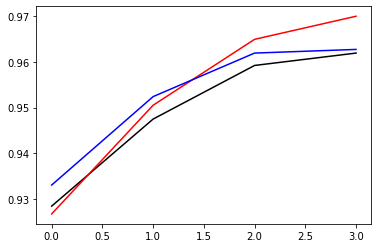

In [43]:
plt.plot(verify_in_test,color='black',label='test')
plt.plot(verify_in_train,color='red',label='train')
plt.plot(verify_in_validate,color='blue',label='validate')
plt.show()

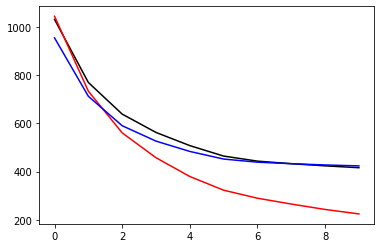

In [33]:
plt.plot(loss_in_test,color='black',label='test')
plt.plot(loss_in_train,color='red',label='train')
plt.plot(loss_in_validate,color='blue',label='validate')
plt.show()